# Import all the required libraries and the dataset

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

import eli5
from eli5.sklearn import PermutationImportance
import shap

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import roc_curve, classification_report

In [2]:
def reduce_mem_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
 
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
temp2_df = reduce_mem_usage(pd.read_csv('temp_df_for_model1.csv'))
temp2_df.drop(['CreditGrade_Not_Applicable','after_July2009','CreditScoreRangeLower','Unnamed: 0'],axis=1,inplace=True)
temp2_df.info()

Memory usage of dataframe is 24.15 MB --> 4.64 MB (Decreased by 80.8%)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   ProsperRating (numeric)        113066 non-null  float32
 1   ProsperScore                   113066 non-null  float32
 2   CreditScoreRangeUpper          113066 non-null  float32
 3   Is_CreditGradeApplicable       113066 non-null  int8   
 4   IsClosed                       113066 non-null  int8   
 5   IsInProgress                   113066 non-null  int8   
 6   IsLate                         113066 non-null  int8   
 7   Is_completed                   113066 non-null  int8   
 8   accompanied_delinquencyBucket  113066 non-null  int8   
 9   CreditGrade_A                  113066 non-null  int8   
 10  CreditGrade_AA                 113066 non-null  int8   
 11  CreditGrade_B       

In [4]:
X_train,X_test,y_train,y_test = train_test_split(temp2_df.drop('Is_completed',axis=1),temp2_df['Is_completed'],test_size=0.25,random_state=1111)

In [6]:
model01 = LogisticRegression(penalty='l1', solver='liblinear', random_state=1111, max_iter=10000)

In [9]:
searcher01 = GridSearchCV(model01, {'C':[0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.6, 1]}, cv=5)
searcher01.fit(X_train, y_train)

print("Best CV params", searcher01.best_params_)

best_lr01 = searcher01.best_estimator_
coefs01 = best_lr01.coef_
print("Total number of features:", coefs01.size)
print("Number of selected features:", np.count_nonzero(coefs01))

Best CV params {'C': 0.01}
Total number of features: 23
Number of selected features: 9


In [10]:
perm01 = PermutationImportance(searcher01, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm01, feature_names = X_test.columns.tolist())

Weight,Feature
0.2298 ± 0.0043,IsInProgress
0.0456 ± 0.0025,IsClosed
0.0122 ± 0.0013,CreditScoreRangeUpper
0.0090 ± 0.0006,IsLate
0.0017 ± 0.0003,Is_CreditGradeApplicable
0.0006 ± 0.0005,ProsperRating (numeric)
0.0004 ± 0.0008,ProsperScore
0 ± 0.0000,CreditGrade_E
0 ± 0.0000,ProsperRating (Alpha)_HR
0 ± 0.0000,ProsperRating (Alpha)_D


In [11]:
y_pred01=best_lr01.predict(X_test)
print(classification_report(y_test,y_pred01))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88     18813
           1       0.71      0.95      0.82      9454

    accuracy                           0.86     28267
   macro avg       0.84      0.88      0.85     28267
weighted avg       0.89      0.86      0.86     28267



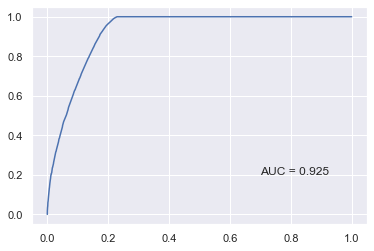

In [12]:
fpr01,tpr01,hp01=roc_curve(y_test,best_lr01.predict_proba(X_test)[:,1])
auc01=roc_auc_score(y_test,best_lr01.predict_proba(X_test)[:,1])
plt.plot(fpr01,tpr01)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc01))
plt.show()

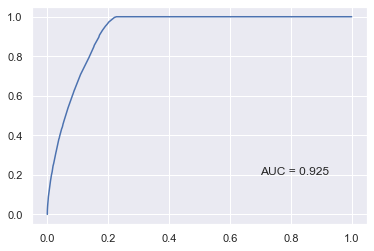

In [13]:
fpr011,tpr011,hp011=roc_curve(y_train,best_lr01.predict_proba(X_train)[:,1])
auc011=roc_auc_score(y_train,best_lr01.predict_proba(X_train)[:,1])
plt.plot(fpr011,tpr011)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc011))
plt.show()

In [14]:
imp_fea=["IsInProgress",
"IsClosed",
"CreditScoreRangeUpper",
"IsLate",
"Is_CreditGradeApplicable",
"ProsperRating (numeric)",
"ProsperScore"]

model02 = LogisticRegression(penalty='l1', solver='liblinear', random_state=1111, max_iter=10000)

searcher02 = GridSearchCV(model02, {'C':[0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.6, 1]}, cv=5)
searcher02.fit(X_train[imp_fea], y_train)

print("Best CV params", searcher02.best_params_)

best_lr02 = searcher02.best_estimator_
coefs02 = best_lr02.coef_
print("Total number of features:", coefs02.size)
print("Number of selected features:", np.count_nonzero(coefs02))

Best CV params {'C': 0.007}
Total number of features: 7
Number of selected features: 7


In [15]:
perm02 = PermutationImportance(searcher02, random_state=1).fit(X_test[imp_fea], y_test)
eli5.show_weights(perm02, feature_names = X_test[imp_fea].columns.tolist())

Weight,Feature
0.2338 ± 0.0028,IsInProgress
0.0407 ± 0.0027,IsClosed
0.0120 ± 0.0009,CreditScoreRangeUpper
0.0090 ± 0.0007,IsLate
0.0019 ± 0.0006,Is_CreditGradeApplicable
0.0006 ± 0.0008,ProsperScore
0.0004 ± 0.0005,ProsperRating (numeric)


In [16]:
y_pred02=best_lr02.predict(X_test[imp_fea])
print(classification_report(y_test,y_pred02))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88     18813
           1       0.71      0.95      0.82      9454

    accuracy                           0.86     28267
   macro avg       0.84      0.88      0.85     28267
weighted avg       0.88      0.86      0.86     28267



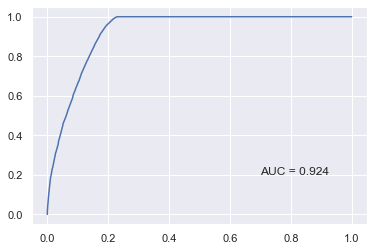

In [17]:
fpr02,tpr02,hp02=roc_curve(y_test,best_lr02.predict_proba(X_test[imp_fea])[:,1])
auc02=roc_auc_score(y_test,best_lr02.predict_proba(X_test[imp_fea])[:,1])
plt.plot(fpr02,tpr02)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc02))
plt.show()

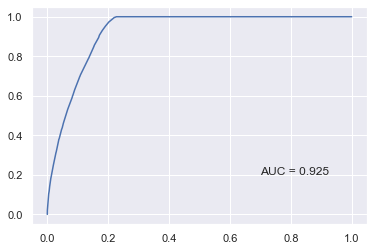

In [18]:
fpr021,tpr021,hp021=roc_curve(y_train,best_lr02.predict_proba(X_train[imp_fea])[:,1])
auc021=roc_auc_score(y_train,best_lr02.predict_proba(X_train[imp_fea])[:,1])
plt.plot(fpr021,tpr021)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc021))
plt.show()

Text(0.5, 1.0, 'Correlation')

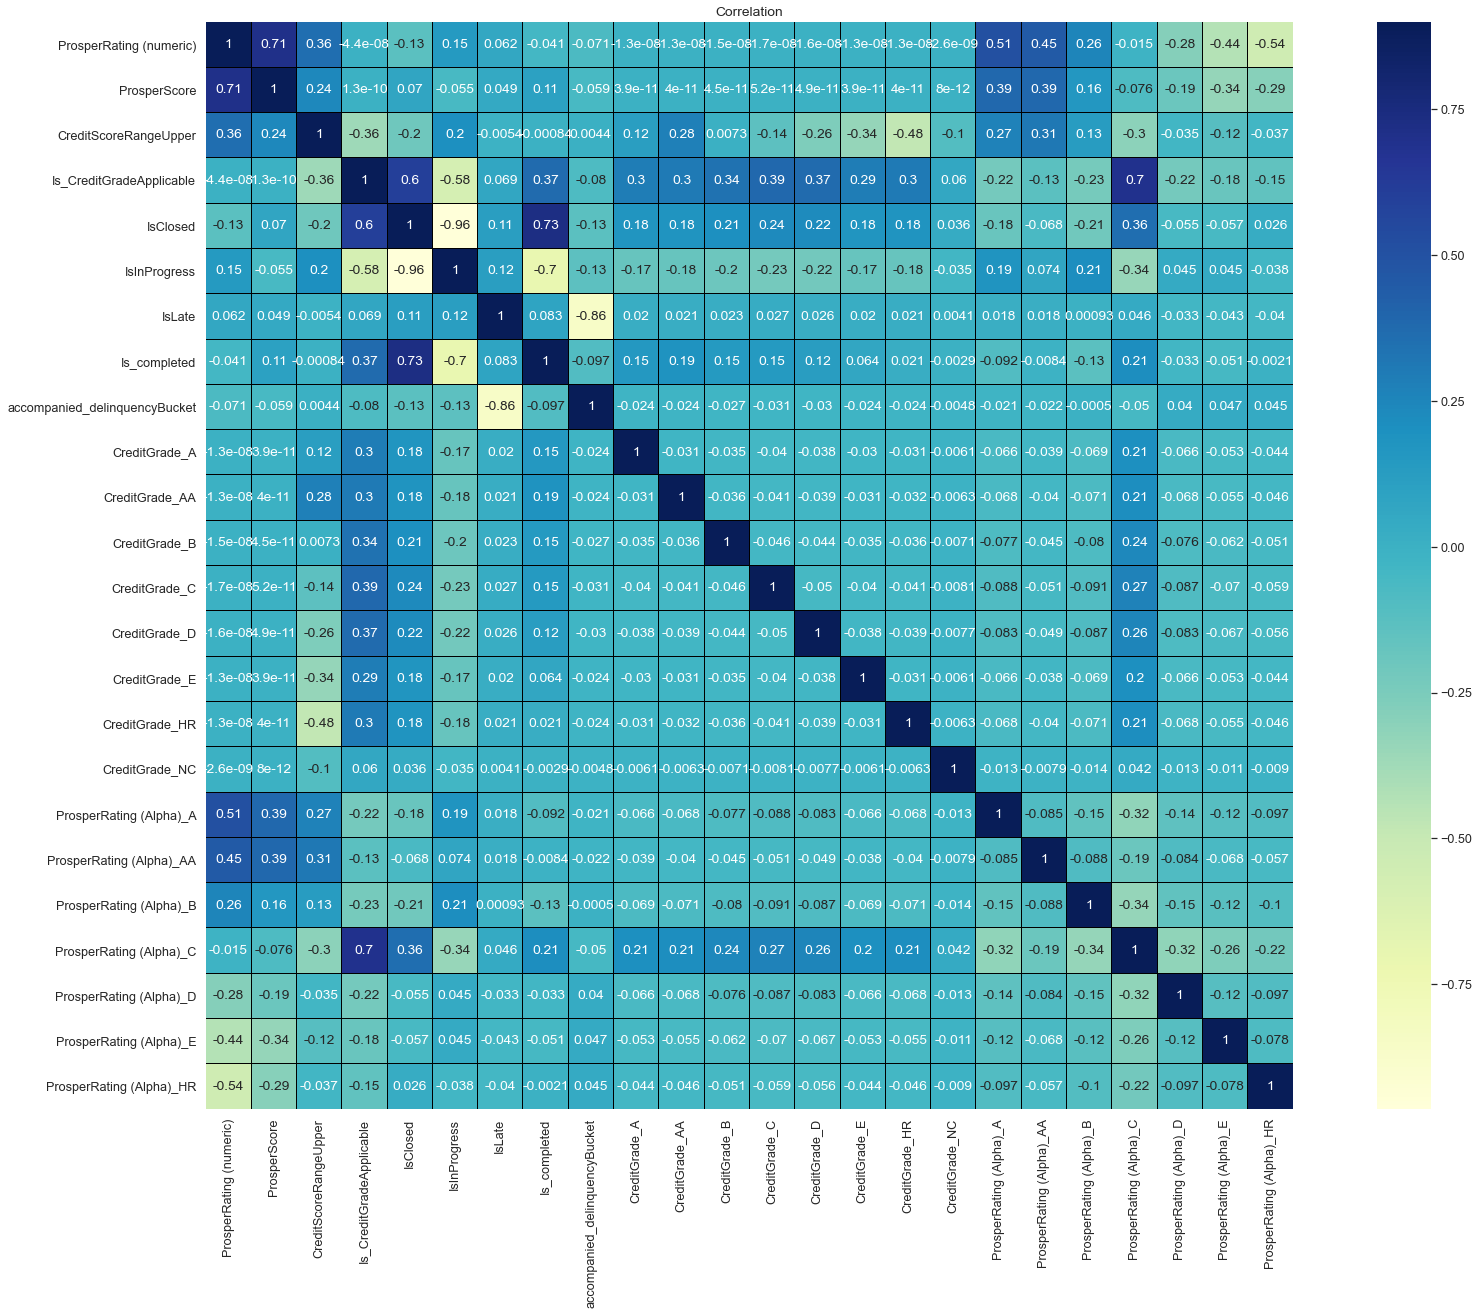

In [19]:
sns.set(font_scale=1.15)
plt.figure(figsize=(30, 20))
sns.heatmap(temp2_df.corr(),  vmax=0.9, linewidths=0.02,
           square=True,
            annot=True,
            cmap='YlGnBu',
            linecolor="black")
plt.title('Correlation')

# -----------------------------------------------------------------------------------------------------------

In [23]:
data = reduce_mem_usage(pd.read_csv("My_final_data_without_missing_values_or_catigorical_features.csv"))
data.drop('Unnamed: 0',axis=1,inplace=True)
data.info()

Memory usage of dataframe is 207.03 MB --> 46.58 MB (Decreased by 77.5%)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Columns: 239 entries, Term to IncomeRange_Not employed
dtypes: float32(63), int8(176)
memory usage: 46.2 MB


In [24]:
data.columns

Index(['Term', 'BorrowerAPR', 'BorrowerRate', 'LenderYield',
       'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn',
       'ProsperRating (numeric)', 'ProsperScore', 'ListingCategory (numeric)',
       ...
       'EmploymentStatus_Retired', 'EmploymentStatus_Self-employed',
       'IncomeRange_$0', 'IncomeRange_$1-24,999', 'IncomeRange_$100,000+',
       'IncomeRange_$25,000-49,999', 'IncomeRange_$50,000-74,999',
       'IncomeRange_$75,000-99,999', 'IncomeRange_Not displayed',
       'IncomeRange_Not employed'],
      dtype='object', length=239)

In [25]:
X_train,X_test,y_train,y_test = train_test_split(
    data.drop('LoanStatus_Completed',axis=1),data['LoanStatus_Completed'],test_size=0.25,random_state=1111)

model03 = LogisticRegression(penalty='l1', solver='liblinear', random_state=1111, max_iter=10000)

searcher03 = GridSearchCV(model03, {'C':[0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.6, 1]}, cv=5)
searcher03.fit(X_train, y_train)

print("Best CV params", searcher03.best_params_)

best_lr03 = searcher03.best_estimator_
coefs03 = best_lr03.coef_
print("Total number of features:", coefs03.size)
print("Number of selected features:", np.count_nonzero(coefs03))

Best CV params {'C': 1}
Total number of features: 238
Number of selected features: 29


In [26]:
perm03 = PermutationImportance(searcher03, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm03, feature_names = X_test.columns.tolist())

Weight,Feature
0.1279 ± 0.0025,IsInProgress
0.0349 ± 0.0014,LoanStatus_Defaulted
0.0044 ± 0.0007,IsLate
0.0018 ± 0.0004,LP_GrossPrincipalLoss
0.0002 ± 0.0001,exclude_recoveries
0.0002 ± 0.0002,LP_CustomerPayments
0.0001 ± 0.0001,IsClosed
0.0000 ± 0.0001,LoanCurrentDaysDelinquent
0.0000 ± 0.0000,LoanOriginalAmount
0 ± 0.0000,CreditGrade_E


In [27]:
y_pred03=best_lr03.predict(X_test)
print(classification_report(y_test,y_pred03))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18813
           1       1.00      1.00      1.00      9454

    accuracy                           1.00     28267
   macro avg       1.00      1.00      1.00     28267
weighted avg       1.00      1.00      1.00     28267



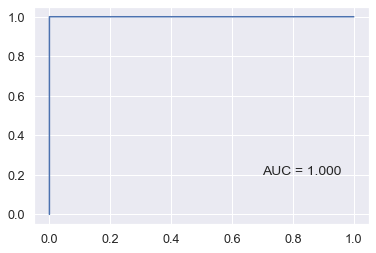

In [28]:
fpr03,tpr03,hp03=roc_curve(y_test,best_lr03.predict_proba(X_test)[:,1])
auc03=roc_auc_score(y_test,best_lr03.predict_proba(X_test)[:,1])
plt.plot(fpr03,tpr03)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc03))
plt.show()

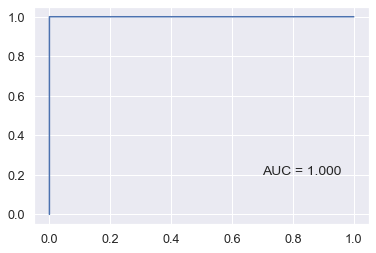

In [29]:
fpr031,tpr031,hp031=roc_curve(y_train,best_lr03.predict_proba(X_train)[:,1])
auc031=roc_auc_score(y_train,best_lr03.predict_proba(X_train)[:,1])
plt.plot(fpr031,tpr031)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc031))
plt.show()

In [31]:
imp_features = ["IsInProgress",
"LoanStatus_Defaulted",
"IsLate",
"LP_GrossPrincipalLoss",
"exclude_recoveries",
"LP_CustomerPayments",
"IsClosed",
"LoanCurrentDaysDelinquent",
"LoanOriginalAmount"]

model04 = LogisticRegression(penalty='l1', solver='liblinear', random_state=1111, max_iter=10000)

searcher04 = GridSearchCV(model04, {'C':[0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.6, 1]}, cv=5)
searcher04.fit(X_train[imp_features], y_train)

print("Best CV params", searcher04.best_params_)

best_lr04 = searcher04.best_estimator_
coefs04 = best_lr04.coef_
print("Total number of features:", coefs04.size)
print("Number of selected features:", np.count_nonzero(coefs04))

Best CV params {'C': 0.03}
Total number of features: 9
Number of selected features: 9


In [32]:
perm04 = PermutationImportance(searcher04, random_state=1).fit(X_test[imp_features], y_test)
eli5.show_weights(perm04, feature_names = X_test[imp_features].columns.tolist())

Weight,Feature
0.4167 ± 0.0048,IsInProgress
0.0504 ± 0.0007,exclude_recoveries
0.0415 ± 0.0013,LoanStatus_Defaulted
0.0217 ± 0.0002,IsLate
0.0178 ± 0.0019,LoanCurrentDaysDelinquent
0.0102 ± 0.0014,LP_GrossPrincipalLoss
0.0034 ± 0.0005,IsClosed
0.0000 ± 0.0000,LP_CustomerPayments
0 ± 0.0000,LoanOriginalAmount


In [33]:
y_pred04=best_lr04.predict(X_test[imp_features])
print(classification_report(y_test,y_pred04))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18813
           1       1.00      1.00      1.00      9454

    accuracy                           1.00     28267
   macro avg       1.00      1.00      1.00     28267
weighted avg       1.00      1.00      1.00     28267



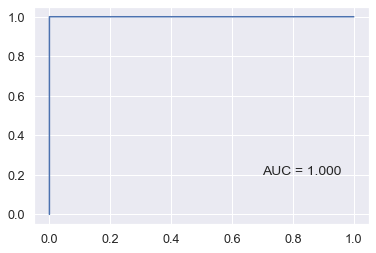

In [34]:
fpr04,tpr04,hp04=roc_curve(y_test,best_lr04.predict_proba(X_test[imp_features])[:,1])
auc04=roc_auc_score(y_test,best_lr04.predict_proba(X_test[imp_features])[:,1])
plt.plot(fpr04,tpr04)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc04))
plt.show()

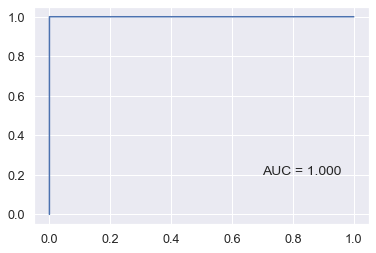

In [35]:
fpr041,tpr041,hp041=roc_curve(y_train,best_lr04.predict_proba(X_train[imp_features])[:,1])
auc041=roc_auc_score(y_train,best_lr04.predict_proba(X_train[imp_features])[:,1])
plt.plot(fpr041,tpr041)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc041))
plt.show()

In [36]:
coefs04

array([[-8.44661385, -7.28487648,  2.06715144, -1.93408066, -6.29586343,
         0.43511133,  4.02014441, -1.86748173, -0.0085024 ]])

In [45]:
imp_features

['IsInProgress',
 'LoanStatus_Defaulted',
 'IsLate',
 'LP_GrossPrincipalLoss',
 'exclude_recoveries',
 'LP_CustomerPayments',
 'IsClosed',
 'LoanCurrentDaysDelinquent',
 'LoanOriginalAmount']

In [60]:
coefs03[abs(coefs03)>0.001]

array([-2.47861169e-01, -2.90491269e-02, -3.31200481e-03,  4.33984671e-02,
       -1.37796981e+00, -6.98239755e-02,  3.37960444e-01, -9.47187255e-01,
       -6.94298734e-01,  1.41158979e+00,  6.20129578e-01, -1.91167072e-01,
        4.01113652e-01,  5.88973357e-02, -1.31826482e+00, -2.69911390e-01,
       -9.24491671e-02, -4.07082855e+00, -5.30360243e+00,  4.42059140e+00,
       -9.01503993e+00,  2.16927675e+00, -2.77055851e+00, -9.32071794e+00,
       -3.05616227e+00, -3.17827761e+00, -1.11393792e+01, -7.23411354e-01,
        2.93505298e-01])

In [61]:
coefs03[abs(coefs03)>1]

array([ -1.37796981,   1.41158979,  -1.31826482,  -4.07082855,
        -5.30360243,   4.4205914 ,  -9.01503993,   2.16927675,
        -2.77055851,  -9.32071794,  -3.05616227,  -3.17827761,
       -11.13937924])

In [62]:
import pickle
with open("first_model.pichle","wb") as file:
    pickle.dump(best_lr04,file)

In [63]:
first_model = pickle.load(open('first_model.pichle','rb'))
first_model.coef_

array([[-8.44661385, -7.28487648,  2.06715144, -1.93408066, -6.29586343,
         0.43511133,  4.02014441, -1.86748173, -0.0085024 ]])

# ---------------------------------------------------------------------------------------------------

In [64]:
temp3_df = reduce_mem_usage(pd.read_csv("datafor_another_models.csv"))
temp3_df.drop('Unnamed: 0',axis=1,inplace=True)
temp3_df.info()

Memory usage of dataframe is 3.45 MB --> 1.40 MB (Decreased by 59.4%)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ProsperScore          113066 non-null  float32
 1   CreditScoreAverage    113066 non-null  float32
 2   LoanStatus_Completed  113066 non-null  int8   
dtypes: float32(2), int8(1)
memory usage: 993.9 KB


In [66]:
train_X,test_X,train_y,test_y = train_test_split(temp3_df.drop('LoanStatus_Completed',axis=1),temp3_df['LoanStatus_Completed'],test_size=0.25,random_state=1111)

In [76]:
model05 = LogisticRegression(penalty='l2', solver='liblinear', random_state=1111, max_iter=10000)

searcher05 = GridSearchCV(model05, {'C':[0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.6, 1]}, cv=5)
searcher05.fit(np.array(train_X['CreditScoreAverage']).reshape(-1, 1), train_y)

print("Best CV params", searcher05.best_params_)

best_lr05 = searcher05.best_estimator_
best_lr05.coef_

Best CV params {'C': 0.001}


array([[-0.00096336]])

In [77]:
y_pred05=best_lr05.predict(np.array(test_X['CreditScoreAverage']).reshape(-1, 1))
print(classification_report(test_y,y_pred05))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80     18813
           1       0.00      0.00      0.00      9454

    accuracy                           0.67     28267
   macro avg       0.33      0.50      0.40     28267
weighted avg       0.44      0.67      0.53     28267



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [78]:
model06 = LogisticRegression(penalty='l2', solver='liblinear', random_state=1111, max_iter=10000)

searcher06 = GridSearchCV(model06, {'C':[0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.6, 1]}, cv=5)
searcher06.fit(np.array(train_X['ProsperScore']).reshape(-1, 1), train_y)

print("Best CV params", searcher06.best_params_)

best_lr06 = searcher06.best_estimator_
best_lr06.coef_

Best CV params {'C': 0.001}


array([[0.04470428]])

In [79]:
y_pred06=best_lr06.predict(np.array(test_X['ProsperScore']).reshape(-1, 1))
print(classification_report(test_y,y_pred06))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80     18813
           1       0.00      0.00      0.00      9454

    accuracy                           0.67     28267
   macro avg       0.33      0.50      0.40     28267
weighted avg       0.44      0.67      0.53     28267



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [80]:
temp3_df['LoanStatus_Completed'].value_counts(normalize=True)

0    0.663374
1    0.336626
Name: LoanStatus_Completed, dtype: float64

#### strange !!!!

# ------------------------------------------------------------------------------------------------------

### I will build model to predict the likelihood of a loan would be high risk or not

In [6]:
data = reduce_mem_usage(pd.read_csv('final_prosper_dataset.csv'))
data.drop('Unnamed: 0',axis=1,inplace=True)

date_cols = ["ListingCreationDate","FirstRecordedCreditLine","DateCreditPulled","LoanOriginationDate"]

for col in date_cols:
    data[col] = pd.to_datetime(data[col])

data.info()

Memory usage of dataframe is 81.09 MB --> 38.71 MB (Decreased by 52.3%)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 93 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ListingCreationDate                  113066 non-null  datetime64[ns]
 1   CreditGrade                          113066 non-null  object        
 2   Term                                 113066 non-null  int8          
 3   LoanStatus                           113066 non-null  object        
 4   ClosedDate                           55076 non-null   object        
 5   BorrowerAPR                          113066 non-null  float32       
 6   BorrowerRate                         113066 non-null  float32       
 7   LenderYield                          113066 non-null  float32       
 8   EstimatedEffectiveYield              113066 non-null  float32       
 9 

In [7]:
data.dropna(axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 82 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   ListingCreationDate                 113066 non-null  datetime64[ns]
 1   CreditGrade                         113066 non-null  object        
 2   Term                                113066 non-null  int8          
 3   LoanStatus                          113066 non-null  object        
 4   BorrowerAPR                         113066 non-null  float32       
 5   BorrowerRate                        113066 non-null  float32       
 6   LenderYield                         113066 non-null  float32       
 7   EstimatedEffectiveYield             113066 non-null  float32       
 8   EstimatedLoss                       113066 non-null  float32       
 9   EstimatedReturn                     113066 non-null  float32       
 10  ProsperR

In [8]:
data2 = reduce_mem_usage(pd.read_csv('final2_prosper_dataset.csv'))
data2.drop('Unnamed: 0',axis=1,inplace=True)

for col in date_cols:
    data2[col] = pd.to_datetime(data2[col])

data2.info()

Memory usage of dataframe is 81.09 MB --> 33.53 MB (Decreased by 58.6%)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 93 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   ListingCreationDate                 113066 non-null  datetime64[ns]
 1   CreditGrade                         113066 non-null  object        
 2   Term                                113066 non-null  int8          
 3   BorrowerAPR                         113066 non-null  float32       
 4   BorrowerRate                        113066 non-null  float32       
 5   LenderYield                         113066 non-null  float32       
 6   EstimatedEffectiveYield             113066 non-null  float32       
 7   EstimatedLoss                       113066 non-null  float32       
 8   EstimatedReturn                     113066 non-null  float32       
 9   ProsperRa

In [14]:
X = pd.get_dummies(data2.drop(date_cols,axis=1).drop('LoanKey',axis=1)
,columns=[col for col in data2.drop(date_cols,axis=1).drop('LoanKey',axis=1).columns if 'O' == data2[col].dtype]).drop('high_risk',axis=1)

y = pd.get_dummies(data2.drop(date_cols,axis=1).drop('LoanKey',axis=1)
,columns=[col for col in data2.drop(date_cols,axis=1).drop('LoanKey',axis=1).columns if 'O' == data2[col].dtype])['high_risk']

# all_data =

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1111)

model10 = LogisticRegression(penalty='l1', solver='liblinear', random_state=1111, max_iter=10000)

searcher10 = GridSearchCV(model10, {'C':[0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.6, 1]}, cv=5)
searcher10.fit(X_train, y_train)

print("Best CV params", searcher10.best_params_)

best_lr10 = searcher10.best_estimator_
coefs10 = best_lr10.coef_
print("Total number of features:", coefs10.size)
print("Number of selected features:", np.count_nonzero(coefs10))

Best CV params {'C': 0.3}
Total number of features: 231
Number of selected features: 50


In [16]:
perm10 = PermutationImportance(searcher10, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm10, feature_names = X_test.columns.tolist())

Weight,Feature
0.4673 ± 0.0047,ProsperScore
0.0056 ± 0.0009,MaxIncome
0.0052 ± 0.0006,MinIncome
0.0026 ± 0.0002,LoanCurrentDaysDelinquent
0.0007 ± 0.0002,MonthlyLoanPayment
0.0005 ± 0.0002,LoanOriginalAmount
0 ± 0.0000,CreditGrade_AA
0 ± 0.0000,CreditGrade_A
0 ± 0.0000,LoanStatus_Past Due (>120 days)
0 ± 0.0000,LoanStatus_FinalPaymentInProgress


In [17]:
y_pred10=best_lr10.predict(X_test)
print(classification_report(y_test,y_pred10))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17670
           1       1.00      1.00      1.00     10597

    accuracy                           1.00     28267
   macro avg       1.00      1.00      1.00     28267
weighted avg       1.00      1.00      1.00     28267



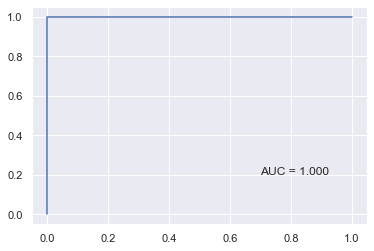

In [18]:
fpr10,tpr10,hp10=roc_curve(y_test,best_lr10.predict_proba(X_test)[:,1])
auc10=roc_auc_score(y_test,best_lr10.predict_proba(X_test)[:,1])
plt.plot(fpr10,tpr10)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc10))
plt.show()

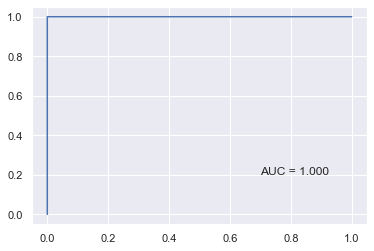

In [19]:
fpr101,tpr101,hp101=roc_curve(y_train,best_lr10.predict_proba(X_train)[:,1])
auc101=roc_auc_score(y_train,best_lr10.predict_proba(X_train)[:,1])
plt.plot(fpr101,tpr101)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc101))
plt.show()

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X.drop('ProsperScore',axis=1),y,test_size=0.25,random_state=1111)

model11 = LogisticRegression(penalty='l1', solver='liblinear', random_state=1111, max_iter=10000)

searcher11 = GridSearchCV(model11, {'C':[0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.6, 1]}, cv=5)
searcher11.fit(X_train, y_train)

print("Best CV params", searcher11.best_params_)

best_lr11 = searcher11.best_estimator_
coefs11 = best_lr11.coef_
print("Total number of features:", coefs11.size)
print("Number of selected features:", np.count_nonzero(coefs11))

Best CV params {'C': 0.3}
Total number of features: 230
Number of selected features: 152


In [21]:
perm11 = PermutationImportance(searcher11, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm11, feature_names = X_test.columns.tolist())

Weight,Feature
0.2623 ± 0.0042,LoanMonthsSinceOrigination
0.1570 ± 0.0034,ProsperRating (numeric)
0.0934 ± 0.0021,LoanCurrentDaysDelinquent
0.0413 ± 0.0015,MinIncome
0.0342 ± 0.0019,LoanOriginalAmount
0.0315 ± 0.0012,after_July2009
0.0294 ± 0.0036,MaxIncome
0.0277 ± 0.0002,CreditGrade_Not_Applicable
0.0236 ± 0.0013,LP_NetPrincipalLoss
0.0192 ± 0.0018,LP_GrossPrincipalLoss


In [22]:
y_pred11=best_lr11.predict(X_test)
print(classification_report(y_test,y_pred11))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90     17670
           1       0.84      0.85      0.84     10597

    accuracy                           0.88     28267
   macro avg       0.87      0.87      0.87     28267
weighted avg       0.88      0.88      0.88     28267



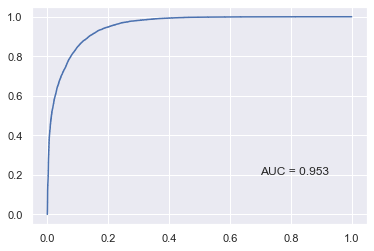

In [23]:
fpr11,tpr11,hp11=roc_curve(y_test,best_lr11.predict_proba(X_test)[:,1])
auc11=roc_auc_score(y_test,best_lr11.predict_proba(X_test)[:,1])
plt.plot(fpr11,tpr11)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc11))
plt.show()

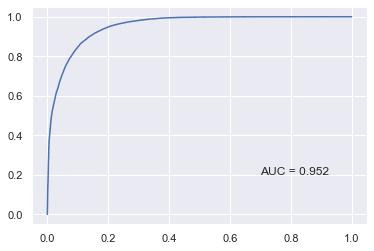

In [24]:
fpr111,tpr111,hp111=roc_curve(y_train,best_lr11.predict_proba(X_train)[:,1])
auc111=roc_auc_score(y_train,best_lr11.predict_proba(X_train)[:,1])
plt.plot(fpr111,tpr111)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc111))
plt.show()

In [25]:
coefs11

array([[-2.01614439e-02,  0.00000000e+00,  0.00000000e+00,
         1.88214592e+00,  0.00000000e+00,  5.19570647e+00,
         6.07295721e+00, -1.45934580e+00, -3.65212324e-02,
         5.43084360e-05,  9.67964820e-02, -8.62727803e-01,
         5.88561382e-03,  4.97139819e-03,  8.59982567e-03,
         1.44093819e-02,  3.38286979e-03, -2.39387716e-02,
         1.02483936e-05,  2.57597632e-01,  3.38768637e-02,
         1.15781195e-01,  1.19869369e-05, -6.76979346e-03,
        -1.00535671e-01,  0.00000000e+00,  1.25775012e-06,
         4.10503546e-01, -3.59244745e-05,  6.46168636e-03,
        -6.96622567e-02,  2.44329771e-01,  1.15774516e+00,
        -1.17128264e-01, -4.95146821e-05,  5.20572419e-03,
        -1.73292218e-01, -1.35821636e-04,  3.03912433e-03,
         1.33519876e-05,  5.97759756e-06,  1.44316618e-04,
        -3.25729916e-03, -1.78803767e-03,  5.44000249e-04,
        -8.26023762e-04,  3.78752098e-04,  0.00000000e+00,
        -6.16551318e-02,  0.00000000e+00,  1.88088791e-0

In [27]:
X.columns[:100]

Index(['Term', 'BorrowerAPR', 'BorrowerRate', 'LenderYield',
       'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn',
       'ProsperRating (numeric)', 'ProsperScore', 'ListingCategory (numeric)',
       'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'CurrentlyInGroup',
       'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'CurrentCreditLines',
       'OpenCreditLines', 'TotalCreditLinespast7years',
       'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment',
       'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies',
       'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'AvailableBankcardCredit', 'TotalTrades',
       'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months',
       'DebtToIncomeRatio', 'IncomeVerifiable', 'StatedMonthlyIncome',
       'LoanCurrentDaysDelinquent', 'LoanMonthsSinceOrigination',
       'L

In [28]:
fe=['LoanMonthsSinceOrigination',
'ProsperRating (numeric)',
'LoanCurrentDaysDelinquent',
'MinIncome',
'LoanOriginalAmount',
'after_July2009',
'MaxIncome',
'CreditGrade_Not_Applicable',
'LP_NetPrincipalLoss',
'LP_GrossPrincipalLoss',
'Is_ChargedOff',
'MonthlyLoanPayment',
'AvailableBankcardCredit',
'exclude_recoveries',
'InquiriesLast6Months',
'had_PriorLoans',
'IncomeRange_Not displayed',
'ProsperRating (Alpha)_D',
'IsInGroup',
'TradesOpenedLast6Months',
'Term', 
'BorrowerAPR', 
'BorrowerRate', 
'LenderYield',
'ListingCategory (numeric)',
'EmploymentStatusDuration', 
'IsBorrowerHomeowner',
'CurrentlyInGroup',
'CreditScoreRangeLower',
'CreditScoreRangeUpper', 
'CurrentCreditLines',
'OpenCreditLines', 
'TotalCreditLinespast7years',
'OpenRevolvingAccounts', 
'OpenRevolvingMonthlyPayment',
'InquiriesLast6Months', 
'TotalInquiries', 
'CurrentDelinquencies',
'AmountDelinquent', 
'DelinquenciesLast7Years',
'PublicRecordsLast10Years', 
'PublicRecordsLast12Months',
'RevolvingCreditBalance', 
'BankcardUtilization',
'AvailableBankcardCredit', 
'TotalTrades',
'TradesNeverDelinquent (percentage)', 
'TradesOpenedLast6Months',
'DebtToIncomeRatio', 
'IncomeVerifiable', 
'StatedMonthlyIncome',
'LoanMonthsSinceOrigination',
'LoanOriginalAmount',
'LP_CustomerPayments',
'LP_CustomerPrincipalPayments', 
'LP_InterestandFees', 
'LP_ServiceFees',
'LP_CollectionFees',
'LP_NonPrincipalRecoverypayments', 
'PercentFunded',
'Recommendations',
'InvestmentFromFriendsCount', 
'InvestmentFromFriendsAmount',
'Investors']
# now we have 64 features 
X_train,X_test,y_train,y_test = train_test_split(X.drop('ProsperScore',axis=1)[fe],y,test_size=0.25,random_state=1111)

model12 = LogisticRegression(penalty='l1', solver='liblinear', random_state=1111, max_iter=10000)

searcher12 = GridSearchCV(model12, {'C':[0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.6, 1]}, cv=5)
searcher12.fit(X_train, y_train)

print("Best CV params", searcher12.best_params_)

best_lr12 = searcher12.best_estimator_
coefs12 = best_lr12.coef_
print("Total number of features:", coefs12.size)
print("Number of selected features:", np.count_nonzero(coefs12))

Best CV params {'C': 0.1}
Total number of features: 64
Number of selected features: 58


In [29]:
perm12 = PermutationImportance(searcher12, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm12, feature_names = X_test.columns.tolist())

Weight,Feature
0.1720 ± 0.0026,ProsperRating (numeric)
0.1277 ± 0.0028,MinIncome
0.1259 ± 0.0010,LoanMonthsSinceOrigination
0.1032 ± 0.0028,LoanMonthsSinceOrigination
0.0947 ± 0.0011,LoanCurrentDaysDelinquent
0.0853 ± 0.0018,MaxIncome
0.0303 ± 0.0021,exclude_recoveries
0.0288 ± 0.0023,after_July2009
0.0272 ± 0.0027,CreditGrade_Not_Applicable
0.0240 ± 0.0011,LP_NetPrincipalLoss


In [30]:
y_pred12=best_lr12.predict(X_test)
print(classification_report(y_test,y_pred12))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90     17670
           1       0.83      0.84      0.84     10597

    accuracy                           0.88     28267
   macro avg       0.87      0.87      0.87     28267
weighted avg       0.88      0.88      0.88     28267



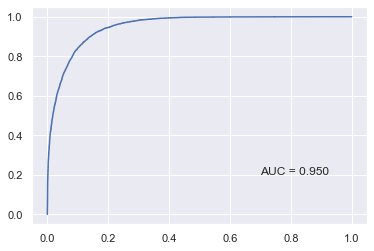

In [31]:
fpr12,tpr12,hp12=roc_curve(y_test,best_lr12.predict_proba(X_test)[:,1])
auc12=roc_auc_score(y_test,best_lr12.predict_proba(X_test)[:,1])
plt.plot(fpr12,tpr12)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc12))
plt.show()

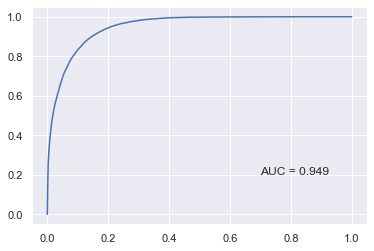

In [32]:
fpr121,tpr121,hp121=roc_curve(y_train,best_lr12.predict_proba(X_train)[:,1])
auc121=roc_auc_score(y_train,best_lr12.predict_proba(X_train)[:,1])
plt.plot(fpr121,tpr121)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc121))
plt.show()